http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf
http://web.media.mit.edu/~tristan/phd/dissertation/index.html

In [1]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

In [77]:
cid ="0cadd882a6ab4ff485c80b8b02aa3b0c" 
secret = "04d0f737e18a4a92abee1da25d70766b"
username = ""

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

scope = 'user-library-read playlist-read-private user-read-recently-played user-read-playback-state user-modify-playback-state'
token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
data = []

analysis = sp.audio_analysis("3m9eTtBtU0xxJndQRz9MOr")
print(analysis["track"]["tempo"])

165.87


In [4]:
X = []
Y = []

for segment in analysis["segments"]:
    if(segment["start"] < 20):
        X.append(segment["pitches"])
        start = segment["start"]
        end = segment["start"] + segment["duration"]
        Y.append(start)

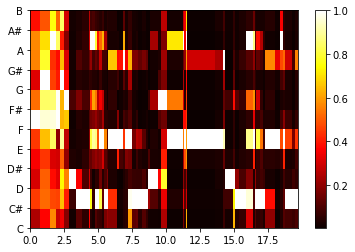

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib as mpl
from scipy.interpolate import interp2d

pitches = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# Set figure width to 12 and height to 9
#fig_size[0] = 24
#fig_size[1] = 8
#plt.rcParams["figure.figsize"] = fig_size

cMap = mpl.cm.hot

plt.pcolormesh(Y, np.arange(12), np.transpose(X), cmap=cMap)
plt.colorbar()
plt.yticks( np.arange(12), pitches )
plt.show()

In [36]:
import networkx as nx
def euc_distance(s1, s2):
    return np.linalg.norm(s1-s2)

def weighted_euc_distance(s1,s2,w):
    q = s1-s2
    return np.sqrt((w*q*q).sum())
def calucate_distance(seg1, seg2):
    pitch_dist = euc_distance(np.array(seg1["pitches"]),np.array(seg2["pitches"]))
    timbre_dist = weighted_euc_distance(np.array(seg1["timbre"]), np.array(seg2["timbre"]),1)
    start_loudness_dist = abs(seg1["loudness_start"] - seg2["loudness_start"])
    max_loudness_dist = abs(seg1["loudness_max"] - seg2["loudness_max"])
    duration_dist = abs(seg1["duration"] - seg2["duration"])
    confidence_dist = abs(seg1["confidence"] - seg2["confidence"])
    distance = timbre_dist + pitch_dist * 10 + start_loudness_dist + max_loudness_dist + duration_dist * 100 + confidence_dist
    return distance
def get_top_four_closest_segments(segment_number):
    segment_distance = []
    for i in range(0, len(analysis["segments"])):
        if i != segment_number:
            distance = calucate_distance(analysis["segments"][segment_number], analysis["segments"][i])
            if(distance < 50 and distance != 0):
                segment_distance.append({"distance": distance, "number": i})
    return sorted(segment_distance, key=lambda x: x["distance"], reverse=False)[0:4]

def make_graph_from_close_segments():
    to = []
    segmentsToAddToGraph = []
    fromArray = []
    for i in range(0, len(analysis["segments"])):
        closestSegments = get_top_four_closest_segments(i)
        for segment in closestSegments:
            segmentObject = {"from": i, "to": segment["number"], "distance": segment["distance"]}
            reverseSegmentObject = {"from": segment["number"], "to": i, "distance": segment["distance"]}
            if reverseSegmentObject not in segmentsToAddToGraph:
                segmentsToAddToGraph.append(segmentObject)
    sortedSegments = sorted(segmentsToAddToGraph, key=lambda x: x["distance"], reverse=False)
    for segment in sortedSegments:
        to.append(segment["to"])
        fromArray.append(segment["from"])
    fromArray = fromArray[0:20]
    to = to[0:20]
    df = pd.DataFrame({ 'from':fromArray, 'to':to })
    G = nx.from_pandas_edgelist(df, "from", "to")
    return G

In [37]:
G = make_graph_from_close_segments()

In [38]:
import random
jumps = []
sourceVerticies = []
#print(Counter(fromEdges))
for u,v in G.edges:
    if random.random() < .5:
        if u not in sourceVerticies:
            print(u, v)
            jumps.append({"from": u, "to": v})
            sourceVerticies.append(u)
        else:
            if v not in sourceVerticies:
                print(v, u)
                jumps.append({"from": v, "to": u})
                sourceVerticies.append(v)
    else:
        if v not in sourceVerticies:
            print(v, u)
            jumps.append({"from": v, "to": u})
            sourceVerticies.append(v)
        else:
            if u not in sourceVerticies:
                print(u, v)
                jumps.append({"from": u, "to": v})
                sourceVerticies.append(u)


38 577
578 39
515 535
498 517
501 521
534 514
510 529
101 147
213 167
496 535
600 33
601 34
35 602
36 603
477 496
222 177
211 165
488 507
490 509
570 63


In [70]:
sp._put("me/player/play", payload = {"uris":["spotify:track:7yNSKfs3tjnh44of1FIF5k"], "offset": {"position": 0}})

In [39]:
i=0
newlist = sorted(jumps, key=lambda k: k['from']) 
while i < len(jumps):
    player = sp._get("me/player")
    if player["progress_ms"] >= analysis["segments"][newlist[i]["from"]]["start"]*1000:
        jump_to = analysis["segments"][newlist[i]["to"]]["start"]*1000
        i=i+1
        sp._put("me/player/seek?position_ms="+str(int(round(jump_to))))

KeyboardInterrupt: 

In [81]:
import random
import networkx as nx
def euc_distance(s1, s2):
    return np.linalg.norm(s1-s2)
def weighted_euc_distance(s1,s2,w):
    q = s1-s2
    return np.sqrt((w*q*q).sum())
def calucate_distance(seg1, seg2):
    pitch_dist = euc_distance(np.array(seg1["pitches"]),np.array(seg2["pitches"]))
    timbre_dist = weighted_euc_distance(np.array(seg1["timbre"]), np.array(seg2["timbre"]),1)
    start_loudness_dist = abs(seg1["loudness_start"] - seg2["loudness_start"])
    max_loudness_dist = abs(seg1["loudness_max"] - seg2["loudness_max"])
    duration_dist = abs(seg1["duration"] - seg2["duration"])
    confidence_dist = abs(seg1["confidence"] - seg2["confidence"])
    distance = timbre_dist + pitch_dist * 10 + start_loudness_dist + max_loudness_dist + duration_dist * 100 + confidence_dist
    return distance
def get_top_four_closest_segments(segment_number):
    segment_distance = []
    for i in range(0, len(analysis["segments"])):
        if i != segment_number:
            distance = calucate_distance(analysis["segments"][segment_number], analysis["segments"][i])
            if(distance < 50 and distance != 0):
                segment_distance.append({"distance": distance, "number": i})
    return sorted(segment_distance, key=lambda x: x["distance"], reverse=False)[0:4]
def getAnalysisForTrack(songID):
    return sp.audio_analysis("3m9eTtBtU0xxJndQRz9MOr")
def makeGraphFromAnalysis(analysis):
    to = []
    segmentsToAddToGraph = []
    fromArray = []
    for i in range(0, len(analysis["segments"])):
        closestSegments = get_top_four_closest_segments(i)
        for segment in closestSegments:
            segmentObject = {"from": i, "to": segment["number"], "distance": segment["distance"]}
            reverseSegmentObject = {"from": segment["number"], "to": i, "distance": segment["distance"]}
            if reverseSegmentObject not in segmentsToAddToGraph:
                segmentsToAddToGraph.append(segmentObject)
    sortedSegments = sorted(segmentsToAddToGraph, key=lambda x: x["distance"], reverse=False)
    for segment in sortedSegments:
        to.append(segment["to"])
        fromArray.append(segment["from"])
    fromArray = fromArray[0:20]
    to = to[0:20]
    df = pd.DataFrame({'from':fromArray, 'to':to })
    G = nx.from_pandas_edgelist(df, "from", "to")
    return G
def makeBranchesToJumpAt(G):
    jumps = []
    sourceVerticies = []
    #print(Counter(fromEdges))
    for u,v in G.edges:
        if random.random() < .5:
            if u not in sourceVerticies:
                print(u, v)
                jumps.append({"from": u, "to": v})
                sourceVerticies.append(u)
            else:
                if v not in sourceVerticies:
                    print(v, u)
                    jumps.append({"from": v, "to": u})
                    sourceVerticies.append(v)
        else:
            if v not in sourceVerticies:
                print(v, u)
                jumps.append({"from": v, "to": u})
                sourceVerticies.append(v)
            else:
                if u not in sourceVerticies:
                    print(u, v)
                    jumps.append({"from": u, "to": v})
                    sourceVerticies.append(u)
    return jumps
def playSongAndJumpAtBranches(branches, songID):
    i=0
    newlist = sorted(jumps, key=lambda k: k['from']) 
    sp._put("me/player/play", payload = {"uris":["spotify:track:"+songID], "offset": {"position": 0}})
    while i < len(jumps):
        player = sp._get("me/player")
        if player["progress_ms"] >= analysis["segments"][newlist[i]["from"]]["start"]*1000:
            jump_to = analysis["segments"][newlist[i]["to"]]["start"]*1000
            i=i+1
            sp._put("me/player/seek?position_ms="+str(int(round(jump_to))))

In [82]:
#Run Function
def run():
    songID = "3m9eTtBtU0xxJndQRz9MOr"
    anlaysis = getAnalysisForTrack(songID)
    G = makeGraphFromAnalysis(analysis)
    branches = makeBranchesToJumpAt(G)
    playSongAndJumpAtBranches(branches, songID)

    
run()

577 38
578 39
535 515
498 517
521 501
514 534
510 529
101 147
167 213
496 535
33 600
601 34
35 602
36 603
477 496
177 222
165 211
488 507
509 490
63 570


KeyboardInterrupt: 